In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_error

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

In [2]:
df = pd.read_csv('../DATA/Frozen_Dessert_Production.csv',index_col='DATE',parse_dates=True)
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [5]:
# changing the column name to Production
df.columns = ['Production']
df.head()

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


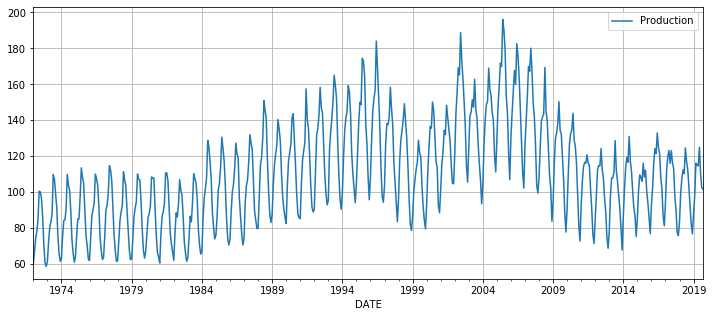

In [6]:
df.plot(figsize=(12,5), grid=True)

## Train Test Split

In [12]:
# len(df)- 24 # 2 years=24 months (testing data)

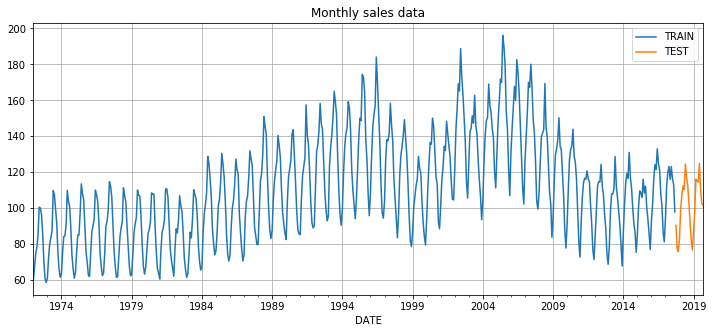

In [29]:
test_size = 24 # 2 years
test_ind = len(df)- test_size

train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

ax = train.plot(figsize=(12,5))
test.plot(ax=ax, grid=True);
ax.legend(['TRAIN', 'TEST'])
ax.set_title('Monthly sales data');

## Scale Data

In [30]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)

scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [31]:
# one must ensure that the length size should be less than the test size
batch_size=1 # for time series data
length = 12 # length of batches
generator = TimeseriesGenerator(data=scaled_train, targets=scaled_train, length=length, 
                                batch_size=batch_size)

In [32]:
n_features = 1

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

early_stop = EarlyStopping(monitor='val_loss',patience=2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [33]:
validation_generator = TimeseriesGenerator(data=scaled_test, targets=scaled_test, 
                                           length=length, batch_size=batch_size)

In [34]:
# fit model
model.fit_generator(generator,epochs=20, validation_data=validation_generator, 
                    callbacks=[early_stop])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 537 steps, validate for 12 steps
Epoch 1/20
537/537 [==============================] - 22s 41ms/step - loss: 0.0206 - val_loss: 0.0024
Epoch 2/20
537/537 [==============================] - 22s 41ms/step - loss: 0.0078 - val_loss: 0.0020
Epoch 3/20
537/537 [==============================] - 19s 36ms/step - loss: 0.0047 - val_loss: 0.0020
Epoch 4/20
537/537 [==============================] - 19s 36ms/step - loss: 0.0040 - val_loss: 0.0022


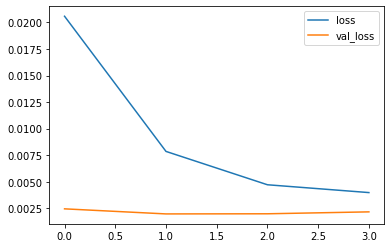

In [35]:
losses = pd.DataFrame(model.history.history)
losses.plot()

## Evaluate on Test Data

In [36]:
test_predictions = []

first_eval_batch = scaled_train[-length:] # the very last batch (points) from the training set
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [37]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions

/home/dhrumpy/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


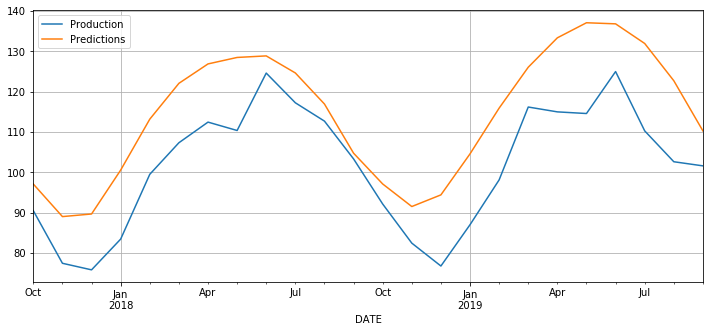

In [38]:
test.plot(figsize=(12,5), grid=True)

### Calculate RMSE

In [42]:
mean_squared_error(test['Production'], test['Predictions'])**0.5

14.09018219877968

In [44]:
df.describe().mean()

Production    161.316977
dtype: float64

# Retrain and Forecasting

In [47]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(data=scaled_full_data, targets=scaled_full_data, 
                                length=length, batch_size=1)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(generator,epochs=20)

  ...
    to  
  ['...']
Train for 561 steps
Epoch 1/20
561/561 [==============================] - 24s 43ms/step - loss: 0.0232
Epoch 2/20
561/561 [==============================] - 19s 34ms/step - loss: 0.0094
Epoch 3/20
561/561 [==============================] - 21s 37ms/step - loss: 0.0055
Epoch 4/20
561/561 [==============================] - 22s 39ms/step - loss: 0.0046
Epoch 5/20
561/561 [==============================] - 20s 35ms/step - loss: 0.0047
Epoch 6/20
561/561 [==============================] - 20s 36ms/step - loss: 0.0039
Epoch 7/20
561/561 [==============================] - 23s 41ms/step - loss: 0.0042
Epoch 8/20
561/561 [==============================] - 21s 38ms/step - loss: 0.0039
Epoch 9/20
561/561 [==============================] - 25s 44ms/step - loss: 0.0037
Epoch 10/20
561/561 [==============================] - 22s 38ms/step - loss: 0.0034
Epoch 11/20
561/561 [==============================] - 21s 38ms/step - loss: 0.0035
Epoch 12/20
561/561 [===================

In [66]:
forecast = []
periods = 12*4 # forecasting for 4 years

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):    
    current_pred = model.predict(current_batch)[0]    
    forecast.append(current_pred)     
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [67]:
forecast = scaler.inverse_transform(forecast)
forecast_index = pd.date_range(start='2019-10-01',periods=periods,freq='MS')
forecast_df = pd.DataFrame(data=forecast,index=forecast_index, columns=['Forecast'])

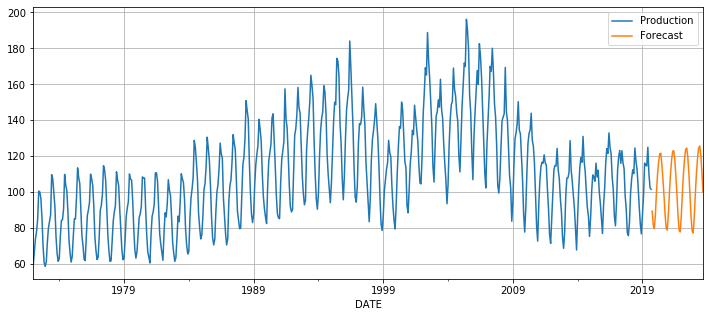

In [68]:
ax = df.plot(figsize=(12,5))
forecast_df.plot(ax=ax, grid=True)